In [ ]:
!pip install tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import os

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, TextVectorization, Dropout
from keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [2]:
def read_data(filename):
    input = pd.read_csv(filename).rename(
        columns={"reviews.text": "text", "reviews.rating": "rating"})
    data = input[input['text'].notna() & input['rating'].notna()][['text','rating']]
    data['text'] = data['text'].apply(
        lambda x: " ".join([word for word in x.split() if 
                            word.lower() not in stop_words and len(word) > 2]))
    
    return train_test_split(data, test_size = 0.1, random_state=0)

In [3]:
def create_vectorize_layer(x_train, vector_type, vocab_size):


    vectorize_layer = TextVectorization(max_tokens = vocab_size, 
                                        output_mode = vector_type)
    
    x_train_tf = tf.data.Dataset.from_tensor_slices(x_train)
    vectorize_layer.adapt(x_train_tf.batch(64))
    # print(vectorize_layer.get_vocabulary())
    return vectorize_layer

In [74]:
def create_mlp(args = None):
    model = Sequential(name = 'Prediction_Model_' + args['Model Name'])
    model.add(keras.Input(shape=(1,), dtype=tf.string))
    model.add(args['vectorize_layer'])
    for layer in args['layers']:
        model.add(Dense(units=layer,activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(units=5, activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=args['learning rate'])
    model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [5]:
def train_mlp(x_train, y_train, args = None):
    y_train = keras.utils.to_categorical(y_train - 1, num_classes = 5)
    model = create_mlp(args)
    history = model.fit(x_train, y_train, epochs = args['epoch'], 
                        batch_size = args['batch size'],
                        validation_split = args['validation_split'])

    return model, history

In [75]:
def train_model(reviews_file, vectorizer):
    train_reviews, test_reviews = read_data(reviews_file)

    args = {
    'validation_split': 0.2,
            'epoch': 50,
            'learning rate': 0.0001,
            'batch size': 128,
            'vectorize_layer': create_vectorize_layer(
                train_reviews['text'], vectorizer, 500),
            'layers': [256,256,128],
    }

    best_model = None
    best_valid_acc = 0
    best_hyper_set = None

    if vectorizer == 'count':
        args['Model Name'] = 'BOW_vectorizer'
    else:
        args['Model Name'] = 'TF-IDF_vectorizer'

    model, history = train_mlp(
        train_reviews['text'], train_reviews['rating'], args)
    validation_accuracy = max(history.history['val_accuracy'])

    if validation_accuracy > best_valid_acc:
        best_model = model
        best_valid_acc = validation_accuracy
        best_hyper_set = args
        best_history = history

    return best_model, best_history, best_hyper_set

In [84]:
def plot_history(history, vectorizer):
    
    def plot(train, val, vectorizer, kind):

        x = np.arange(1, np.size(train) + 1)

        plt.plot(x, train, label = "training " + kind)
        plt.plot(x, val, label = "validation " + kind)
        plt.xlabel("epoch")
        plt.ylabel(kind)
        plt.title("training and validation " + kind + " v epoch"  + ' - ' + vectorizer)
        plt.show()
        
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    train_acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']

    # plot
    plot(train_loss_history, val_loss_history, vectorizer, 'loss')
    plot(train_acc_history, val_acc_history, vectorizer, 'accuracy')

In [ ]:
bow_model, bow_model_history, bow_model_hyper_set = train_model('consumer.csv','count')
tfidf_model, tfidf_model_history, tfidf_model_hyper_set = train_model('consumer.csv','tf_idf')

In [86]:
def analyze_model(test, model, model_hyper_set, history):

    print(model.summary())
    print('------------------------------------------------------------------')
    plot_history(history, model_hyper_set['Model Name'])
    print('------------------------------------------------------------------')
    
    predicted = np.argmax(model.predict(test['text']), axis = 1) + 1
    test_df = pd.DataFrame({'Review':test['text'],'Rating':test['rating'],
                            'Predicted Rating':predicted})
    test_df['Difference'] = test_df['Rating'] - test_df['Predicted Rating']
    test_df['Prediction Correct'] = test_df['Difference'] == 0

    prediction_accuracy = test_df['Prediction Correct'].mean()
    print('Prediction Accuracy of Model: ', prediction_accuracy)

    display(test_df)
    print('------------------------------------------------------------------')

    def plot(srs, x, y, title):
        plt.bar(srs.index, srs)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(title)
        plt.show()
    
    difference_freq = test_df['Difference'].value_counts()
    display(difference_freq)

    prediction_by_label = test_df.groupby('Rating')['Prediction Correct'].mean()
    display(prediction_by_label)

    plot(difference_freq, 'Diff between Actual and Predicted Rating', 'Frequency',
         'Frequency of the diff between Actual and Predicted Rating' + ' - ' + \
         model_hyper_set['Model Name'])
    plot(prediction_by_label, 'Label', 'Prediction Accuracy', 
         'Prediction Accuracy by Label' + ' - ' + model_hyper_set['Model Name'])
    print('------------------------------------------------------------------')
    print('------------------------------------------------------------------')

In [10]:
_, test_reviews = read_data('consumer.csv')

<ipython-input-10-39182111333e>:1: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  _, test_reviews = read_data('consumer.csv')


Model: "Prediction_Model_BOW_vectorizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 dense_20 (Dense)            (None, 256)               128256    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                   

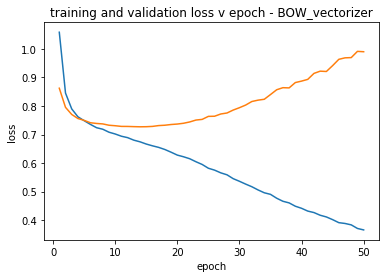

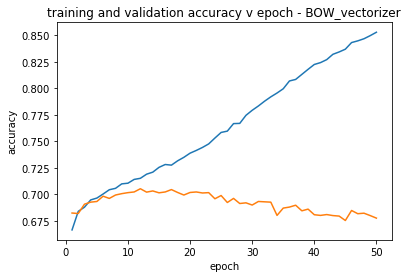

------------------------------------------------------------------
109/109 [==============================] - 1s 7ms/step
Prediction Accuracy of Model:  0.6846664741553566


,Review,Rating,Predicted Rating,Difference,Prediction Correct
32300,Works good streaming apps gaming apps,5.0,4,1.0,False
29751,prefer anything else there. might partial Amaz...,5.0,5,0.0,True
9192,money good deal. Nice hook cell phones.,4.0,4,0.0,True
21351,upgraded older kindle backlit. quality ease us...,5.0,5,0.0,True
27041,Absolutely LOVE Echo! Sound much louder expect...,5.0,5,0.0,True
...,...,...,...,...,...
15674,can't update Facebook apps. expected.,2.0,4,-2.0,False
66,"great tablet price. kid loves ,does alot readi...",5.0,5,0.0,True
17884,"Compact, light, extremely easy eyes reading.",5.0,5,0.0,True
20354,nook love new Kindle much easier use,5.0,5,0.0,True


------------------------------------------------------------------


 0.0    2371
-1.0     614
 1.0     317
-2.0      69
 2.0      36
-3.0      29
-4.0      17
 3.0       6
 4.0       4
Name: Difference, dtype: int64

Rating
1.0    0.200000
2.0    0.000000
3.0    0.164179
4.0    0.302924
5.0    0.869674
Name: Prediction Correct, dtype: float64

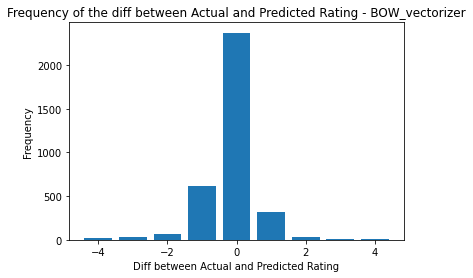

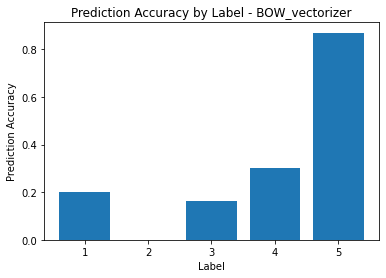

------------------------------------------------------------------
------------------------------------------------------------------
Model: "Prediction_Model_TF-IDF_vectorizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 500)              1         
 ectorization)                                                   
                                                                 
 dense_24 (Dense)            (None, 256)               128256    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                              

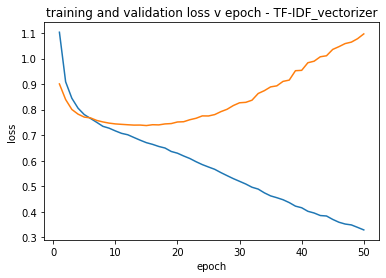

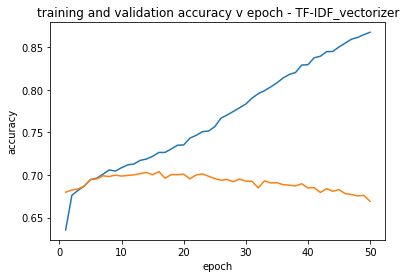

------------------------------------------------------------------
109/109 [==============================] - 0s 3ms/step
Prediction Accuracy of Model:  0.6800462027144095


,Review,Rating,Predicted Rating,Difference,Prediction Correct
32300,Works good streaming apps gaming apps,5.0,4,1.0,False
29751,prefer anything else there. might partial Amaz...,5.0,5,0.0,True
9192,money good deal. Nice hook cell phones.,4.0,4,0.0,True
21351,upgraded older kindle backlit. quality ease us...,5.0,5,0.0,True
27041,Absolutely LOVE Echo! Sound much louder expect...,5.0,5,0.0,True
...,...,...,...,...,...
15674,can't update Facebook apps. expected.,2.0,3,-1.0,False
66,"great tablet price. kid loves ,does alot readi...",5.0,5,0.0,True
17884,"Compact, light, extremely easy eyes reading.",5.0,5,0.0,True
20354,nook love new Kindle much easier use,5.0,5,0.0,True


------------------------------------------------------------------


 0.0    2355
-1.0     591
 1.0     369
-2.0      71
-3.0      28
 2.0      20
-4.0      17
 3.0       8
 4.0       4
Name: Difference, dtype: int64

Rating
1.0    0.125000
2.0    0.050000
3.0    0.134328
4.0    0.329825
5.0    0.855472
Name: Prediction Correct, dtype: float64

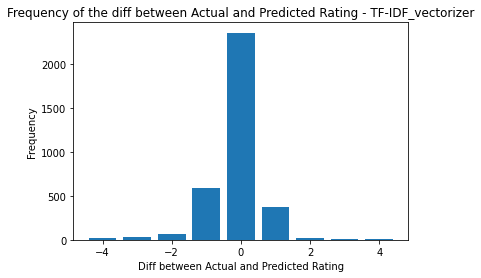

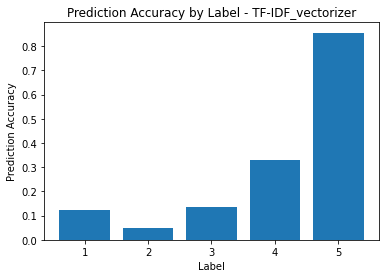

------------------------------------------------------------------
------------------------------------------------------------------


In [87]:
analyze_model(test_reviews, bow_model, bow_model_hyper_set, bow_model_history)
analyze_model(test_reviews, tfidf_model, tfidf_model_hyper_set, tfidf_model_history)